In [1]:
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sb
import numpy as np

Now, we do the exact same thing as we did on handwritten digits from scikit. We use mnist dataset instead. We're still using logistic regression with softmax so it'll be interesting to see the achievable accuracy. 

In [2]:
# load the full dataset and display it
(train_X, train_y), (test_X, test_y) = mnist.load_data()
print(train_y)

[5 0 4 ... 5 6 8]


In [3]:
print("Training Set Details")
print("Target Categories:", np.unique(train_y))
print("Features: ", train_X.shape, train_X.dtype)
print("Classes:", train_y.shape, train_y.dtype)

print("Classes:", train_y)
print("Feature range:", np.min(train_X).astype(np.int32), np.max(train_X).astype(np.int32))
print("Feature type:",train_X.dtype)
print("Target type:",train_y.dtype)

Training Set Details
Target Categories: [0 1 2 3 4 5 6 7 8 9]
Features:  (60000, 28, 28) uint8
Classes: (60000,) uint8
Classes: [5 0 4 ... 5 6 8]
Feature range: 0 255
Feature type: uint8
Target type: uint8


In [4]:
print("Test Set Details")
print("Target Categories:", np.unique(test_y))
print("Features: ", test_X.shape, test_X.dtype)
print("Classes:", test_y.shape, test_y.dtype)

print("Classes:", test_y)
print("Feature range:", np.min(test_X).astype(np.int32), np.max(test_X).astype(np.int32))
print("Feature type:",test_X.dtype)
print("Target type:",test_y.dtype)

Test Set Details
Target Categories: [0 1 2 3 4 5 6 7 8 9]
Features:  (10000, 28, 28) uint8
Classes: (10000,) uint8
Classes: [7 2 1 ... 4 5 6]
Feature range: 0 255
Feature type: uint8
Target type: uint8


The mnist data is already split for us in two different sets. The training set and the test set are big. 70K values once combined. Also pixel data is ranged from 0-255 so we need to rescale it. Firstly, let's visualize some of the training set and see what we can discover.

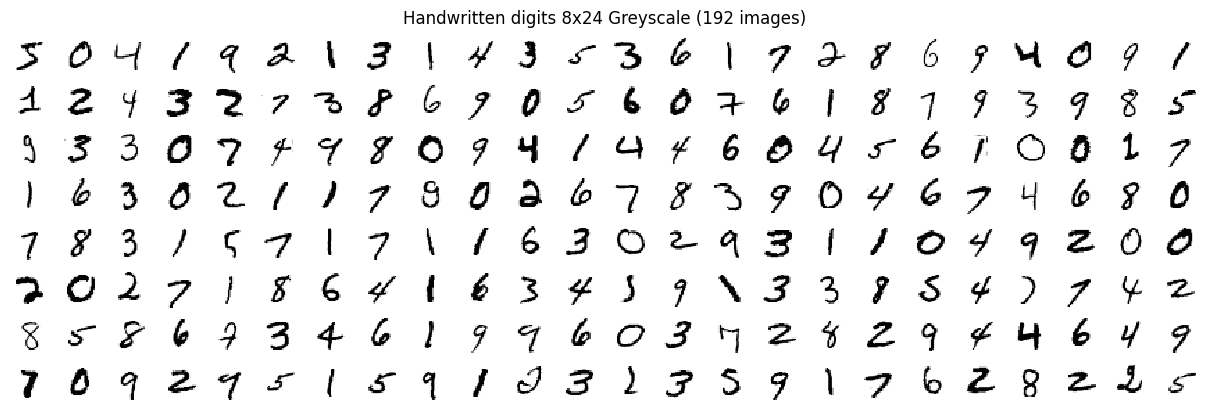

In [5]:
wsize = 24
hsize = 8
fig, axes = plt.subplots(hsize,wsize,figsize=(wsize/2,hsize/2),layout="constrained")

c = 0
for i in range(hsize):
    for j in range(wsize):
        axes[i][j].imshow(train_X[c].reshape((28,28)), interpolation='none', cmap=cm.Greys)
        axes[i][j].axis('off')
        c += 1
plt.suptitle(f"Handwritten digits {hsize}x{wsize} Greyscale ({wsize*hsize} images)")
plt.show()

Here are the first 192 images in the dataset. The images are actually 28x28 so it's actually really high quality. Previously we only had 8x8 digits which made it much simpler to work with. With 28x28, it's easy to represent the same digit in many different ways. 

In [6]:
def feature_scale(data_unscaled, scaled=True):
    if scaled == False:
        return data_unscaled

    max_value = np.max(data_unscaled)

    data_scaled = np.array(data_unscaled)
    data_scaled = data_scaled / max_value
    # min max normalization
    
    return data_scaled

train_X = feature_scale(train_X, scaled=True) # feature scale the training set
test_X = feature_scale(test_X, scaled=True) # feature scale the test set

Here, we just scale both the training set and the test set just like last time. We also need to reshape the features to match what we expect.

In [7]:
train_size = train_X.shape[0]
test_size = test_X.shape[0]
train_X = train_X.reshape((train_size,-1)) # reshape the training set
test_X = test_X.reshape((test_size,-1)) # reshape the test set
print("TrainX:",train_X.shape)
print("TestX:",test_X.shape)

TrainX: (60000, 784)
TestX: (10000, 784)


In [8]:
def add_bias_weight(data):
    m = data.shape[0]
    ones_feature = np.ones(m).reshape((-1,1)) # create a single feature of ones
    data_bias = np.hstack([data, ones_feature])
    return data_bias

train_X_bias = add_bias_weight(train_X)
test_X_bias = add_bias_weight(test_X)
print("TrainX+Bias:",train_X_bias.shape)
print("TestX+Bias:",test_X_bias.shape)

TrainX+Bias: (60000, 785)
TestX+Bias: (10000, 785)


Now, everything basically stays the same. We just need to perform gradient descent with the correct hyperparameters and try to make it achieve the best possible accuracy. 

In [9]:
def softmax(x):
    ez = np.exp(x)
    return ez / np.sum(ez, axis=1).reshape((-1,1))

In [10]:
def predict(w, x, epsilon=1e-15):
    prediction = np.matmul(x, w) # m k
    softmax_predict = softmax(prediction) # pass it through a softmax
    prediction = np.clip(softmax_predict, epsilon, 1 - epsilon) # clip to avoid overflow issues
    return prediction

In [11]:
def onehot_matrix(a):
    a = a.flatten()
    categories = np.unique(a).shape[0]
    return np.eye(categories)[a]

In [12]:
def log_loss_cost(w,x,y):
    onehot = onehot_matrix(y) # m k
    softmax_prob = predict(w, x) # m k
    overk = onehot * np.log(softmax_prob) # m k
    overm = np.sum(overk, axis=1) # m
    return -np.mean(overm) # 1

In [13]:
def compute_gradients(w,x,y):
    m = x.shape[0] # number of training examples
    onehot = onehot_matrix(y) # m k
    softmax_prob = predict(w, x) # m k
    diff = softmax_prob - onehot # m k
    dw = np.matmul(x.T, diff) / m # n k
    return dw

In [14]:
def show_cost_graph(costs, title, color):
    iterations = costs.shape[0]
    iteration_array = np.arange(0, iterations, dtype=np.int32)
    
    # graph the cost after updating the model
    _, cost_graph = plt.subplots(layout='constrained')
    
    cost_graph.set_xlabel("Epoch")
    cost_graph.set_ylabel("Cost")
    
    cost_graph.set_title(title)
    
    cost_graph.plot(iteration_array, costs, color=color)

Previously, we zeroed out the weights. We can also randomize the weights so every run will have different descent times.

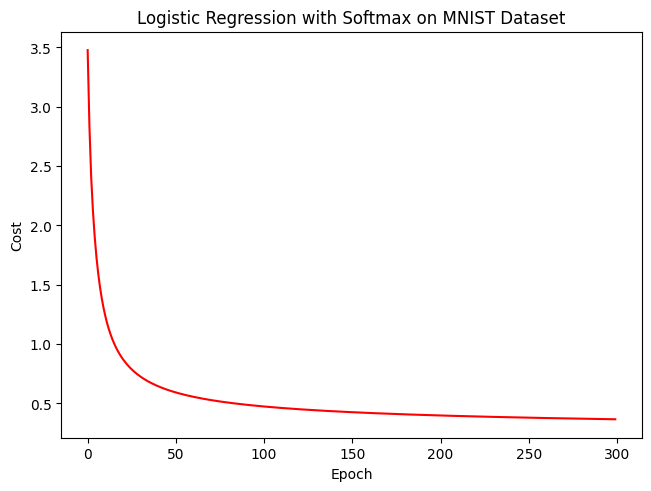

In [15]:
def gradient_descent(x, y, gradient_func, cost_func, learning_rate=0.01, max_iterations=1000):
    y = y.reshape((-1,1))
    m = x.shape[0] # number of training examples
    n = x.shape[1] # number of features
    k = np.unique(y).shape[0] # number of categories

    w = np.random.random((n, k)) # n by k weights
    # initialize model parameters to random values
    costs = np.empty(0)

    for i in range(max_iterations):
        dw = gradient_func(w,x,y)
        w -= learning_rate * dw
        # update the weights
        
        current_cost = cost_func(w,x,y)
        costs = np.append(costs, current_cost)
        # add to array for visualization
    return w, costs
weights, costs = gradient_descent(train_X_bias, train_y, compute_gradients, log_loss_cost, learning_rate=0.5, max_iterations=300)
show_cost_graph(costs, "Logistic Regression with Softmax on MNIST Dataset", "red")

In [16]:
print("Initial cost",costs[0])
print("Final cost",costs[-1])

Initial cost 3.477466694343277
Final cost 0.3664159014277681


Wait, look at this. The final cost is not much better than the initial cost. This means that the model really didn't learn properly. Also, when I ran this, it was really slow to execute. This is because the matrices are so big $(60K, 784)$ just for the feature matrix, that it actually takes quite a while to do matrix multiplication on such an enormous matrix. Eventually, I'll have to use mini-batch gradient descent to make the matrices much smaller and execution time much faster.

In [17]:
def get_prediction_categories(probabilities):
    return np.argmax(probabilities,axis=1)

In [18]:
train_samples = train_X_bias.shape[0]
prediction_train_set_prob = predict(weights, train_X_bias)
prediction_train_samples = get_prediction_categories(prediction_train_set_prob)
score_percentage = accuracy_score(train_y, prediction_train_samples) * 100
print("Accuracy:",round(score_percentage, 2),"%") # show accuracy till 2 decimal places
misclassifications = int(accuracy_score(train_y, prediction_train_samples, normalize=False))
print("Misclassifications:",train_samples - misclassifications)

Accuracy: 89.44 %
Misclassifications: 6334


Very interesting. The accuracy is around 89% on the training set. Let's look at the test set accuracy now. 

In [19]:
test_samples = test_X_bias.shape[0]
prediction_test_set_prob = predict(weights, test_X_bias)
prediction_test_samples = get_prediction_categories(prediction_test_set_prob)
score_percentage = accuracy_score(test_y, prediction_test_samples) * 100
print("Accuracy:",round(score_percentage, 2),"%") # show accuracy till 2 decimal places
misclassifications = int(accuracy_score(test_y, prediction_test_samples, normalize=False))
print("misclassifications:",test_samples - misclassifications)

Accuracy: 89.71 %
misclassifications: 1029


Hmm this is very unexpected. At one hand, I expected the model to only achieve around 60% but it actually achieves nearly 90% accuracy which is definitely very impressive. On the contrary, no matter how many times I tune the model's hyperparameters, the accuracy is stuck around 90%. This shows that we have a bias problem. Also since both training and test accuracy are close, it means that the model hasn't really overfit and we simply need a better model instead.

In [20]:
model = LogisticRegression()
model.fit(train_X, train_y)

C:\Users\abhin\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [21]:
y_train_scikit = model.predict(train_X)
score_percentage = accuracy_score(train_y, y_train_scikit) * 100
print("Accuracy:",round(score_percentage, 2),"%") # show accuracy till 2 decimal places
misclassifications = int(accuracy_score(train_y, y_train_scikit, normalize=False))
print("Misclassifications:",train_samples - misclassifications)

Accuracy: 93.51 %
Misclassifications: 3897


On the training set, scikit achieved ~$93$% so considerably higher than ours. Also, scikit warns us that it hasn't converged so clearly logistic regression isn't enough for this dataset. Now for the test set. 

In [22]:
y_test_scikit = model.predict(test_X)
score_percentage = accuracy_score(test_y, y_test_scikit) * 100
print("Accuracy:",round(score_percentage, 2),"%") # show accuracy till 2 decimal places
misclassifications = int(accuracy_score(test_y, y_test_scikit, normalize=False))
print("Misclassifications:",test_samples - misclassifications)

Accuracy: 92.58 %
Misclassifications: 742


Ok, nearly the same result from scikit. This big accuracy different from our model is very notable though. Just like last time, let's see which images it misclassified.

In [23]:
y_difference = prediction_test_samples == test_y
misclassified_indices = np.argwhere(y_difference==False).reshape(-1)
misclassifications = misclassified_indices.shape[0]
print(misclassified_indices) # indices where we misclassified

[   8   33   46 ... 9980 9982 9986]


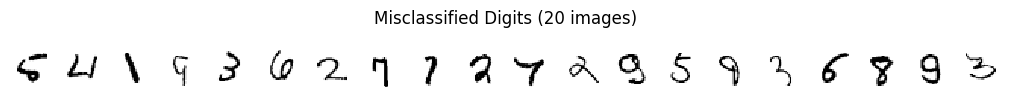

In [31]:
misclassify_plots = min(misclassifications, 20)
fig, axes = plt.subplots(1,misclassify_plots,figsize=(10,1),layout="constrained")

for i in range(misclassify_plots):
        axes[i].imshow(test_X[misclassified_indices[i]].reshape((28,28)), interpolation='none', cmap=cm.Greys)
        axes[i].axis('off')
plt.suptitle(f"Misclassified Digits ({misclassify_plots} images)")
plt.show()

Unlike last time, the misclassifications are odd since these images look really clean to us. But some of the images have odd printing such as 4 without the vertical underline or rotated 3, or a 1 that's close to a 7, etc. This also hints to us that we have a high bias problem where the problem fails to learn the important features of the digits. Just like last time, let's summarize the model and see what's happening.

In [32]:
categories = weights.shape[1]
scaler = MinMaxScaler()
scaler.fit(weights) # fit the weights
scaled_weights = scaler.transform(weights) # get new scaled weights

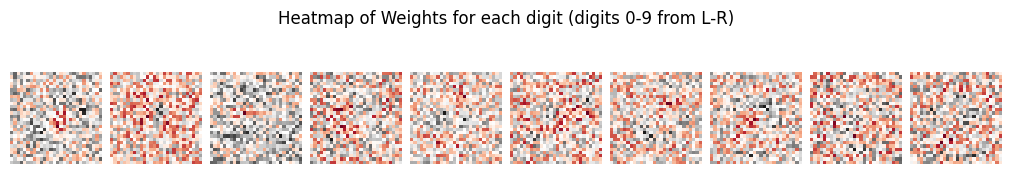

In [33]:
fig, axes = plt.subplots(1,categories,figsize=(10,2),layout="constrained")
scaled_weightsT = scaled_weights.T
scaled_weightsT = scaled_weightsT[:,:-1] # remove the bias feature we manually added
for i in range(categories):
        axes[i].imshow(scaled_weightsT[i].reshape((28,28)), interpolation='none', cmap=cm.RdGy)
        axes[i].axis('off')
plt.suptitle(f"Heatmap of Weights for each digit (digits 0-9 from L-R)")
plt.show()

We have much bigger images now but I can already notice many patterns especially with the black and white pixels. If you look hard enough, it's very noticeable to us which digits the images are classifying. Like last time, black pixels are positive correlation and red pixels are negative correlation. Let's now visualize the confusion matrix again.

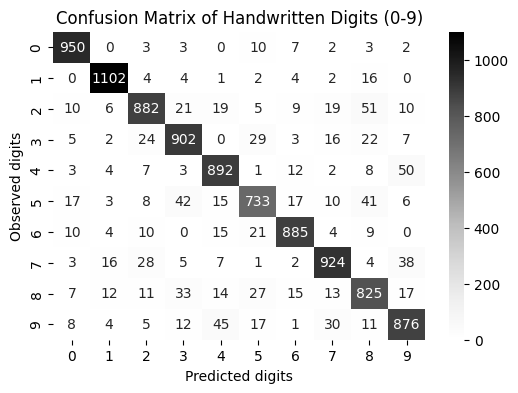

In [34]:
cm_digits = confusion_matrix(test_y, prediction_test_samples)
plt.figure(figsize=(6, 4))
ax = sb.heatmap(cm_digits,annot=True, fmt='d', cmap='Greys')
plt.title("Confusion Matrix of Handwritten Digits (0-9)")
plt.ylabel("Observed digits")
plt.xlabel("Predicted digits")
plt.show()

From this matrix, a lot can be observed. The model fails to recognize that some 3's are actually 2's. It also mistakes many 9's as 4's and 7's. By this point, from the earlier images, it should be obvious that this makes sense to us. I won't even look at the dataset frequencies as that is unnecessary now. Anyways, using softmax regression on mnist has led us to a few insights. 1. Since the dataset is so large, we must use mini batch gradient descent where we train only some subset of the training samples. This should greatly alleviate the large matrix multiplications problem we have and also speed up execution. 2. Also, we have shown that we have a high bias problem with only 90% accuracy. We simply need a better model than the one we're using. Given these 2 important points, it's still impressive to get around 90% accuracy by only using logistic regression. This shows us the power of a simple logistic regression model. 